<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Pion testing

Importing pion sample data for training and testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/pion_predictions/'

pion_predictions_train = np.load(dir + 'pion_predictions_train.npy')
pion_predictions_test = np.load(dir + 'pion_predictions_test.npy')

print('Training data shape:', pion_predictions_train.shape)
print('Test data shape:', pion_predictions_test.shape)

Training data shape: (947947, 128)
Test data shape: (524521, 128)


# Toy example

1. Generate a $\mathcal{N}(0,1)$ distribution.
2. Estimate its density through KDE.
3. Compute the likelihood of several points as their evaluation in the KDE.

**Expected result:** The likelihoods decrease as the evaluation points grow further apart from 0.

Likelihood of 0 in KDE: 99.84%
Likelihood of 1 in KDE: 66.66%
Likelihood of 2 in KDE: 14.27%
Likelihood of 3 in KDE: 1.49%


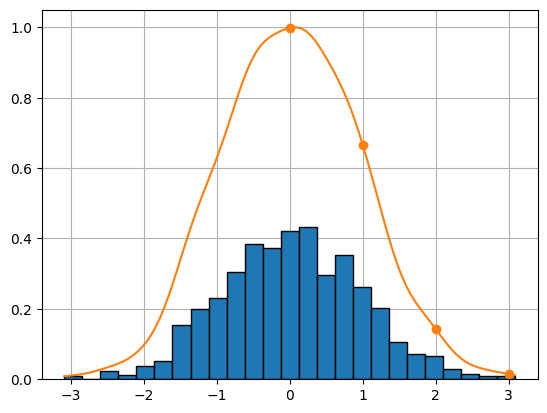

In [ ]:
def likelihood(kde, kde_max, value):
  return kde(value) / kde_max

data = np.random.normal(0, 1, 1000)
kde = gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
kde_x = kde(x)
kde_max = kde_x.max()

points = 0, 1, 2, 3
likelihoods = likelihood(kde, kde_max, points)

for point, like in zip(points, likelihoods):
  print(f'Likelihood of {point} in KDE: {round(100 * like, 2)}%')

plt.gca().set_axisbelow(True)
plt.grid()
plt.hist(data, 25, density=True, edgecolor='black')
plt.plot(x, likelihood(kde, kde_max, x))
plt.scatter(points, likelihoods, color='tab:orange')
plt.show()

# Results

In [ ]:
def plot_hist_kde(ax, d, data, kde):
  x = np.linspace(data.min(), data.max(), 100)
  ax.set_title(f'Dimension {d + 1}')
  ax.hist(data, 25, density=True)
  ax.plot(x, kde(x))

def estimate_likelihoods(train_data, test_data, eps=.01, n_samples=None, n_features=None, plot_shape=None):
  if not n_samples:
    n_samples = test_data.shape[0] # 524521 observations

  if not n_features:
    n_features = train_data.shape[1] # 128 dimensions

  if plot_shape:
    n_subplots = plot_shape[0] * plot_shape[1]

    if n_features != n_subplots:
      raise ValueError(f'Cannot plot {n_features} features in {n_subplots} subplots.')

    rows, columns = plot_shape
    fig, axes = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))

  likelihoods = np.zeros((n_samples, n_features))

  for j in range(n_features):
    train_sample = train_data[:10000, j]
    kde = gaussian_kde(train_sample)

    for i in range(n_samples):
      point = test_data[i, j]
      likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

    if plot_shape:
      plot_hist_kde(axes.flat[j], j, train_sample, kde)

  if plot_shape:
    plt.tight_layout()
    plt.show()

  return likelihoods

likelihoods = estimate_likelihoods(pion_predictions_train, pion_predictions_test, n_samples=128)

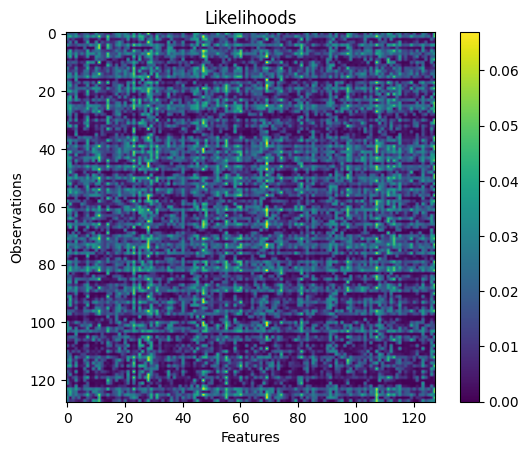

In [ ]:
def plot_likelihoods(likelihoods):
  plt.title('Likelihoods')
  plt.imshow(likelihoods)
  plt.xlabel('Features')
  plt.ylabel('Observations')
  plt.colorbar()
  plt.show()

plot_likelihoods(likelihoods)

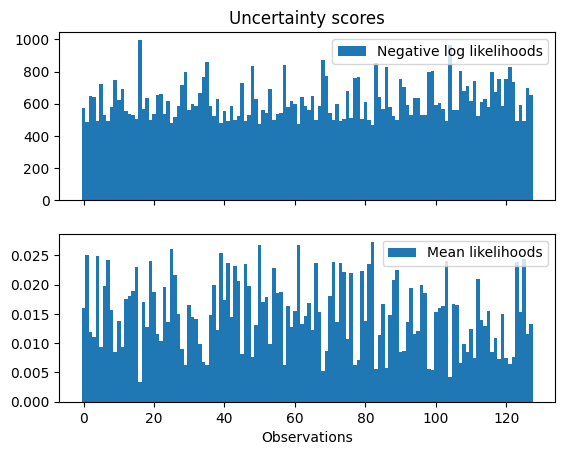

In [ ]:
def mean_likelihood(likelihoods):
  return likelihoods.mean(1)

def log_likelihood(likelihoods):
  likelihoods = likelihoods.copy()
  likelihoods[likelihoods == 0] = .01
  return np.log(likelihoods).sum(1)

def plot_likelihoods(ax, x, likelihoods, label):
  ax.bar(x, likelihoods, 1, label=label)
  ax.legend()

def plot_ue(likelihoods):
  log_likelihoods = log_likelihood(likelihoods)
  mean_likelihoods = mean_likelihood(likelihoods)

  fig, axes = plt.subplots(2, 1, sharex=True)
  x = range(likelihoods.shape[0])

  axes[0].set_title('Uncertainty scores')
  plot_likelihoods(axes[0], x, -log_likelihoods, 'Negative log likelihoods')
  plot_likelihoods(axes[1], x, mean_likelihoods, 'Mean likelihoods')
  axes[1].set_xlabel('Observations')
  plt.show()

plot_ue(likelihoods)

# Proton testing

In [8]:
dll_columns = 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt'

dir = 'drive/MyDrive/Colab Notebooks/outputs/proton/'

train_feats = np.load(dir + 'train_feats.npy')
train_targets = np.load(dir + 'train_targets.npy')
test_feats = np.load(dir + 'test_feats.npy')
test_targets = np.load(dir + 'test_targets.npy')

train_embeddings = np.load(dir + 'train_embeddings.npy')
train_predictions = np.load(dir + 'train_predictions.npy')
test_embeddings = np.load(dir + 'test_embeddings.npy')
test_predictions = np.load(dir + 'test_predictions.npy')

print('Train feats shape:', train_feats.shape)
print('Train targets shape:', train_targets.shape)
print('Test feats shape:', test_feats.shape)
print('Test targets shape:', test_targets.shape)

print('Train embeddings shape:', train_embeddings.shape)
print('Train predictions shape:', train_predictions.shape)
print('Test embeddings shape:', test_embeddings.shape)
print('Test predictions shape:', test_predictions.shape)

feats = np.concatenate((train_feats, test_feats))
targets = np.concatenate((train_targets, test_targets))
predictions = np.concatenate((train_predictions, test_predictions))

Train feats shape: (454690, 3)
Train targets shape: (454690, 5)
Test feats shape: (272463, 3)
Test targets shape: (272463, 5)
Train embeddings shape: (454690, 128)
Train predictions shape: (454690, 5)
Test embeddings shape: (272463, 128)
Test predictions shape: (272463, 5)


# Likelihood generation / loading

Generating likelihoods through integration for first 10k samples.

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
n_samples, n_features = 10000, test_embeddings.shape[1]
integral_likelihoods = np.zeros((n_samples, n_features))
eps = .01

for j in range(n_features):
  train_sample = train_embeddings[:10000, j]
  kde = gaussian_kde(train_sample)

  for i in range(n_samples):
    point = test_embeddings[i, j]
    integral_likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

np.save(dir + 'integral_likelihoods.npy', integral_likelihoods)

Generating likelihoods through range mapping for first 10k samples.

In [ ]:
n_samples, n_features = 10000, test_embeddings.shape[1]
range_map_likelihoods = np.zeros((n_samples, n_features))

for j in range(n_features):
  train_sample = train_embeddings[:10000, j]
  kde = gaussian_kde(train_sample)

  x = np.linspace(train_sample.min(), train_sample.max(), 10000)
  kde_max = kde(x).max()

  for i in range(n_samples):
    point = test_embeddings[i, j]
    range_map_likelihoods[i, j] = kde(point) / kde_max

np.save(dir + 'range_map_likelihoods.npy', range_map_likelihoods)

<ipython-input-5-3aa1435b3c6a>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  range_map_likelihoods[i, j] = kde(point) / kde_max


Load likelihoods from file if the runtime environment has been disconnected.

In [ ]:
integral_likelihoods = np.load(dir + 'integral_likelihoods.npy')

mean_integral_likelihoods = integral_likelihoods.mean(1)

In [6]:
range_map_likelihoods = np.load(dir + 'range_map_likelihoods.npy')

mean_range_map_likelihoods = range_map_likelihoods.mean(1)

# Correlation plotting

Plot correlation for first 10k samples.

Correlation coefficient for RichDLLe: 99.42%
Correlation coefficient for RichDLLk: -24.07%
Correlation coefficient for RichDLLmu: 98.76%
Correlation coefficient for RichDLLp: 34.93%
Correlation coefficient for RichDLLbt: 60.58%


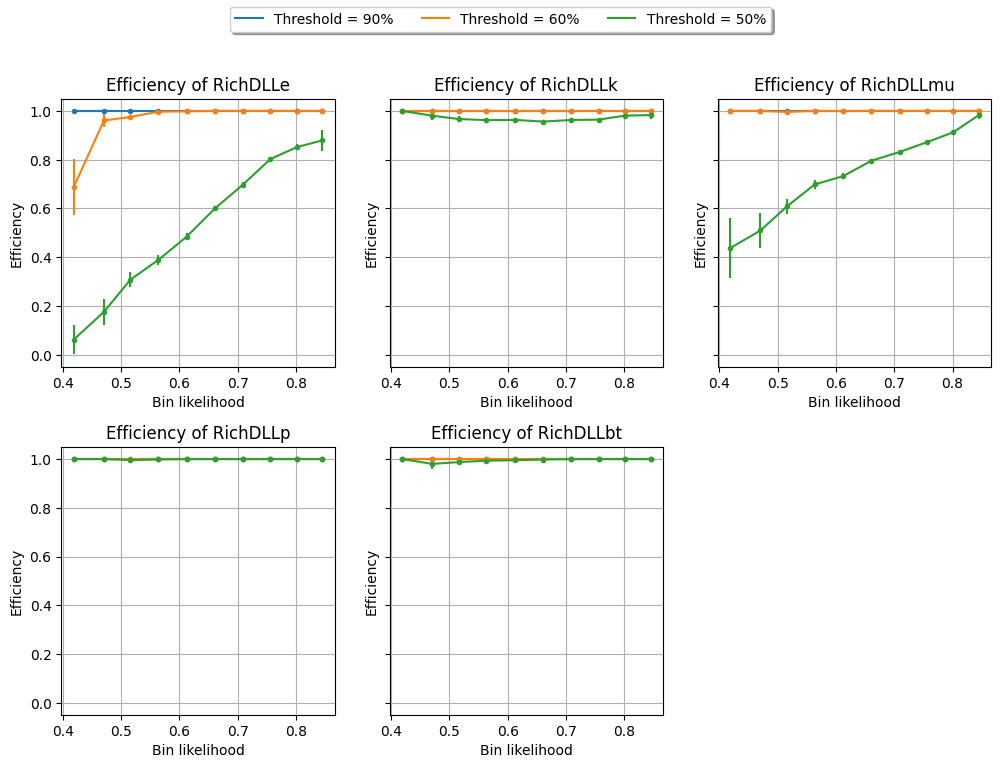

In [9]:
from scipy.stats import linregress

def select_threshold(feature, n_tracks_fraction=0.9):
    return np.quantile(feature, 1 - n_tracks_fraction)

def efficiency_bins(targets, threshold, idx):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiency = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, idx])
        err = compute_error(target[:, idx])

        efficiency.append(eff)
        errors.append(err)

    return efficiency, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)

  indices[indices == 0] = 1
  indices[indices == n_bins + 1] = n_bins

  return indices

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace = .3)

n_bins = 10

indices = compute_bin_indices(mean_range_map_likelihoods, n_bins)

bins_targets = [test_predictions[:10000][indices == i] for i in range(1, n_bins + 1)]
bins_likelihoods = [mean_range_map_likelihoods[indices == i].mean() for i in range(1, n_bins + 1)]

for idx, ax in zip(range(5), axes.flatten()):
    for fraction in .9, .6, .5:
        threshold = select_threshold(train_targets[:, idx], fraction)

        eff, err = efficiency_bins(bins_targets, threshold, idx)
        plot = ax.plot(bins_likelihoods, eff, label=f'Threshold = {int(fraction * 100)}%')
        ax.errorbar(bins_likelihoods, eff, err, fmt='.', color=plot[0].get_color())

    regress = linregress(bins_likelihoods, eff)
    print(f'Correlation coefficient for {dll_columns[idx]}: {round(regress.rvalue * 100, 2)}%')

    ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Bin likelihood")
    ax.set_ylabel("Efficiency")
    ax.grid()

axes[-1, -1].axis(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=3)

plt.show()

# Proton distributions

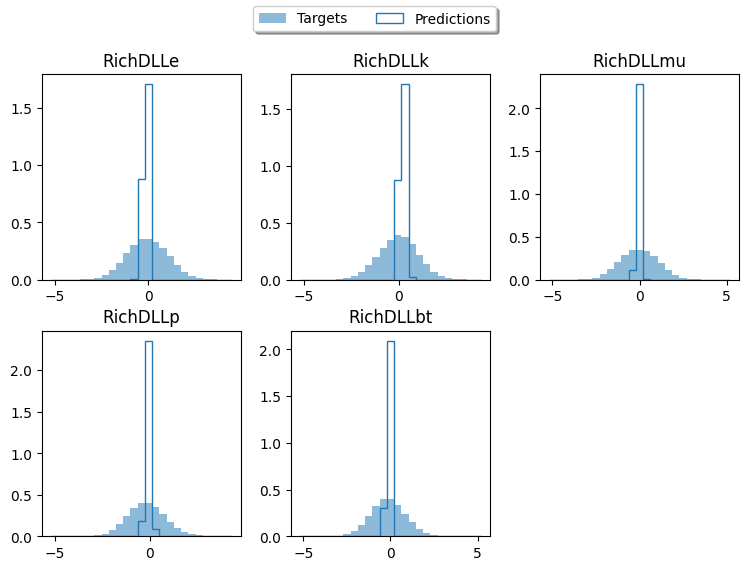

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
plt.subplots_adjust(wspace = .25, hspace = .25)

for i, ax in zip(range(5), axes.flatten()):
  ax.set_title(dll_columns[i])

  hist_range = targets[:, i].min(), targets[:, i].max()

  ax.hist(targets[:, i], 25, hist_range, True, alpha=.5, label='Targets')
  ax.hist(predictions[:, i], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')

axes[-1, -1].axis(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=3)
plt.show()

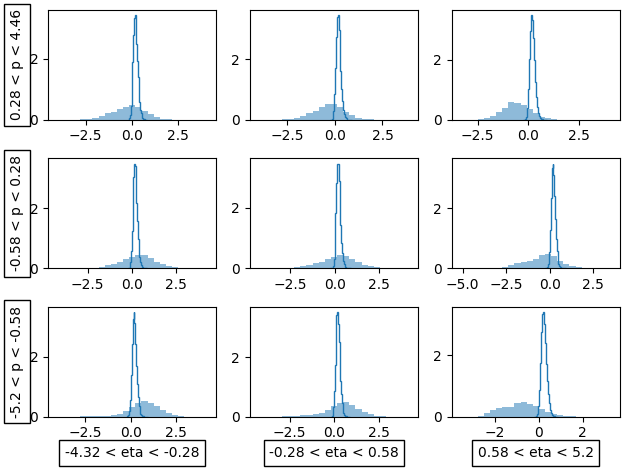

In [26]:
fig, axes = plt.subplots(3, 3)

momentum, eta = feats[:, 0], feats[:, 1]

momentum_bin_edges = np.quantile(momentum, (0, 1/3, 2/3, 1))
eta_bin_edges = np.quantile(eta, (0, 1/3, 2/3, 1))

for i in range(3):
  min_p, max_p = momentum_bin_edges[i], momentum_bin_edges[i + 1]
  bin_momentum_indices = (min_p < momentum) & (momentum < max_p)

  for j in range(3):
    min_eta, max_eta = eta_bin_edges[j], eta_bin_edges[j + 1]
    bin_eta_indices = (min_eta < eta) & (eta < max_eta)

    bin_targets = targets[:, 1][bin_momentum_indices & bin_eta_indices]
    bin_predictions = predictions[:, 1][bin_momentum_indices & bin_eta_indices]

    axes[-i - 1, j].hist(bin_targets, 25, density=True, alpha=.5)
    axes[-i - 1, j].hist(bin_predictions, 25, density=True, histtype='step', color='tab:blue')

for i in range(3):
  min_p, max_p = momentum_bin_edges[i], momentum_bin_edges[i + 1]
  min_eta, max_eta = eta_bin_edges[i], eta_bin_edges[i + 1]

  min_p, max_p = round(min_p, 2), round(max_p, 2)
  min_eta, max_eta = round(min_eta, 2), round(max_eta, 2)

  xlabel = axes[-1, i].set_xlabel(f'{min_eta} < eta < {max_eta}')
  ylabel = axes[-i - 1, 0].set_ylabel(f'{min_p} < p < {max_p}')

  xlabel.set_bbox({'facecolor': 'none'})
  ylabel.set_bbox({'facecolor': 'none'})

plt.tight_layout()
plt.show()